# House prices - advanced regression techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boost

This is my second project out of ten, on my path to learn, understand and apply machine learning. The objectives of this project are:

- Predicting the price of a house given its characteristics.

- "Hello World!" of regression problems.

Dataset from [https://www.kaggle.com/c/house-prices-advanced-regression-techniques/](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description)

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm
from scipy.stats import boxcox

import warnings
    
warnings.filterwarnings("ignore")


In [2]:
# Load data
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

## Data exploration
### Understanding the target variable

In [3]:
print("Skewness: %f" % train_data['SalePrice'].skew())
print("Kurtosis: %f" % train_data['SalePrice'].kurt())


Skewness: 1.882876
Kurtosis: 6.536282


### Correlation matrix

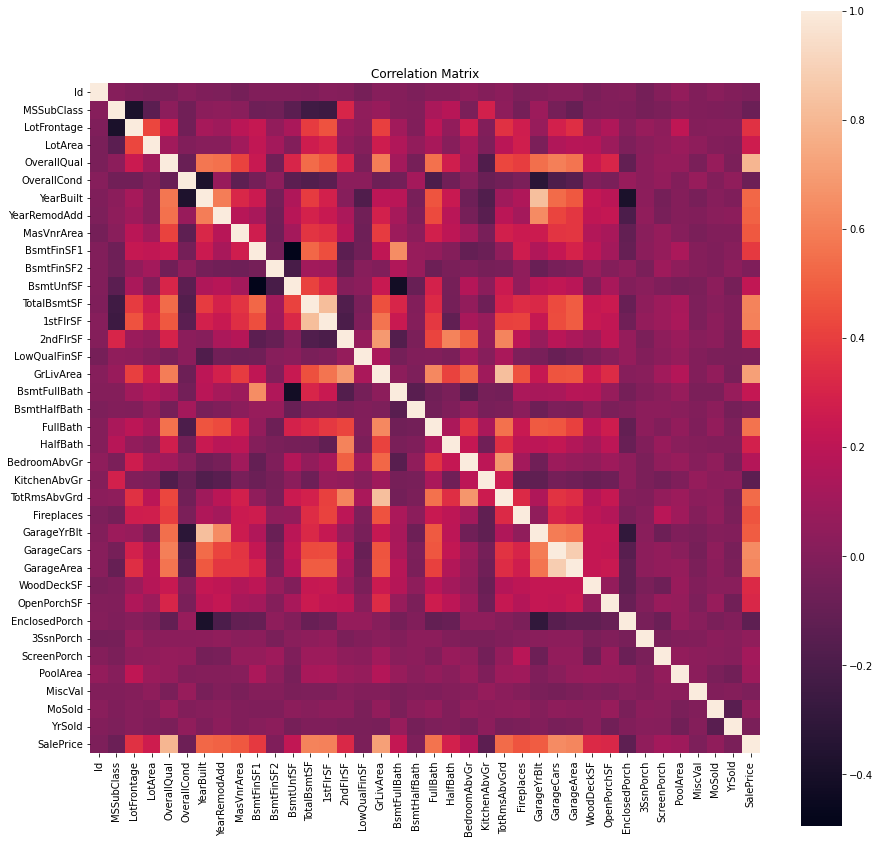

In [4]:
# Correlation matrix
corr_mat = train_data.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_mat, square=True).set(title="Correlation Matrix");


### 'SalePrice' correlation matrix (zoomed)

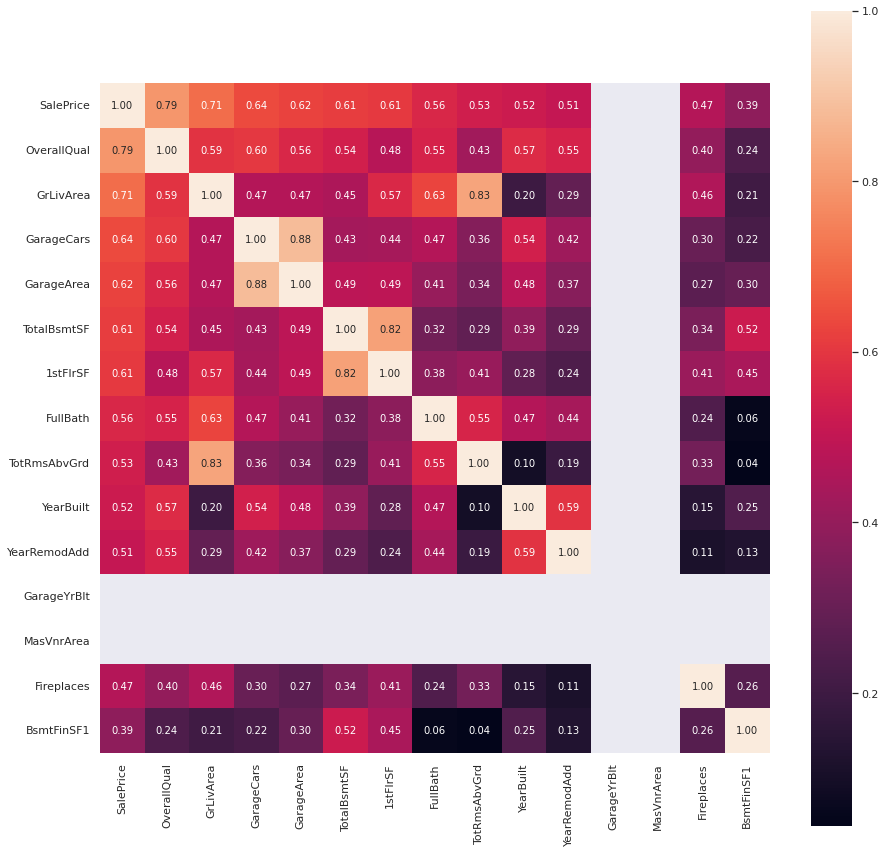

In [5]:
# SalePrice correlation matrix
k = 15  # number of variables for heatmap
cols = corr_mat.nlargest(k, "SalePrice")["SalePrice"].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
sns.set(rc={'figure.figsize':(15,15)})
hm = sns.heatmap(
    cm,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=cols.values,
    xticklabels=cols.values,
)
plt.show()


"GarageCars" and "GarageArea" are highly correlated between them so I will drop "GarageCars" because it is slighty more correlated with "SalePrice".

"TotalBsmntSF" and "1stFlrSF" are also highly correlated between them, so I will drop "1stFlrSF".

"FullBath", "TotRmsAbvGrd" and "YearBuilt" also influence in our target variable.

"OverallQuall", "GrLivArea", "TotalBsmtSF" are strongly correlated with "SalePrice".





### Scatter plots between 'Sale Price' and correlated variables

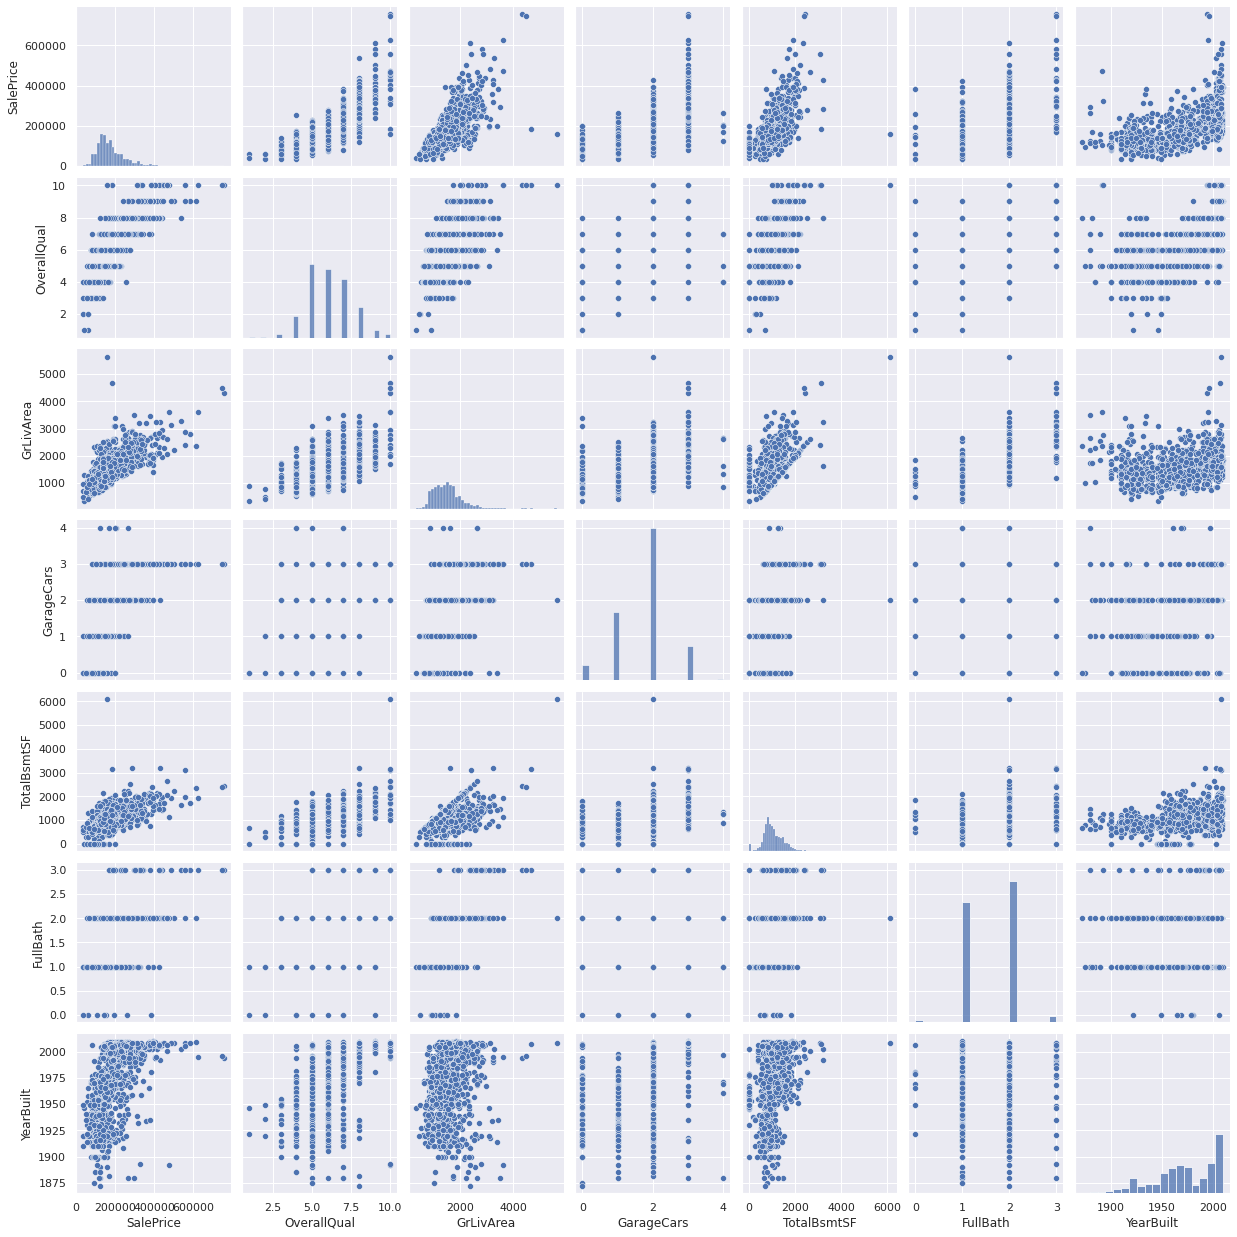

In [6]:
sns.set()
corr_feats = [
    "SalePrice",
    "OverallQual",
    "GrLivArea",
    "GarageCars",
    "TotalBsmtSF",
    "FullBath",
    "YearBuilt",
]
sns.pairplot(train_data[corr_feats], size=2.5)
plt.show()


## Cleaning the data

In [7]:


train_data = _deepnote_execute_sql("""SELECT
    "Id",
    "SalePrice",
    "OverallQual",
    "GrLivArea",
    "GarageCars",
    "TotalBsmtSF",
    "FullBath",
    "YearBuilt"
FROM train_data
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
train_data

,Id,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
0,1,208500,7,1710,2,856,2,2003
1,2,181500,6,1262,2,1262,2,1976
2,3,223500,7,1786,2,920,2,2001
3,4,140000,7,1717,3,756,1,1915
4,5,250000,8,2198,3,1145,2,2000
...,...,...,...,...,...,...,...,...
1455,1456,175000,6,1647,2,953,2,1999
1456,1457,210000,6,2073,2,1542,2,1978
1457,1458,266500,7,2340,1,1152,2,1941
1458,1459,142125,5,1078,1,1078,1,1950


In [8]:
# Check for missing values
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum() / train_data.isnull().count()).sort_values(
    ascending=False
)
missing_data = pd.concat([total, percent * 100], axis=1, keys=["Total", "Percent"])
missing_data


,Total,Percent
Id,0,0.0
SalePrice,0,0.0
OverallQual,0,0.0
GrLivArea,0,0.0
GarageCars,0,0.0
TotalBsmtSF,0,0.0
FullBath,0,0.0
YearBuilt,0,0.0


## Processing the data

### Removing outliers

In [9]:
numerical_features = ["GrLivArea", "TotalBsmtSF"]
target_variable = "SalePrice"


def bivariate_analysis(feature, target_variable):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.scatterplot(x=train_data[feature], y=train_data[target_variable], ax=ax).set(
        title="Bivariate analysis SalePrice/%s" % feature
    )


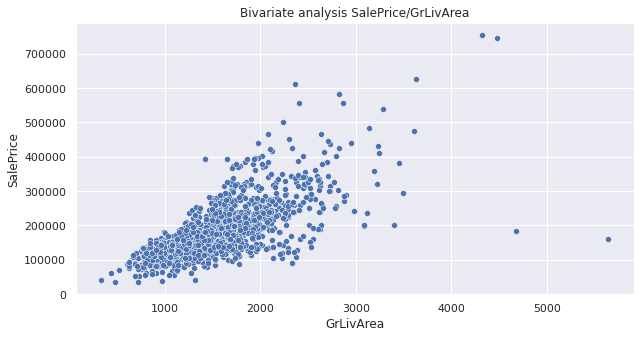

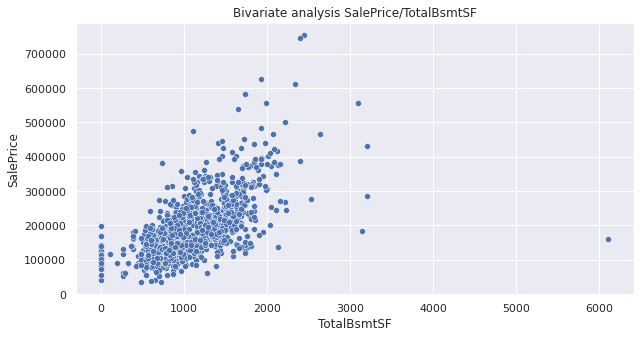

In [10]:
# Bivariate analysis
for feature in numerical_features:
    bivariate_analysis(feature, target_variable)


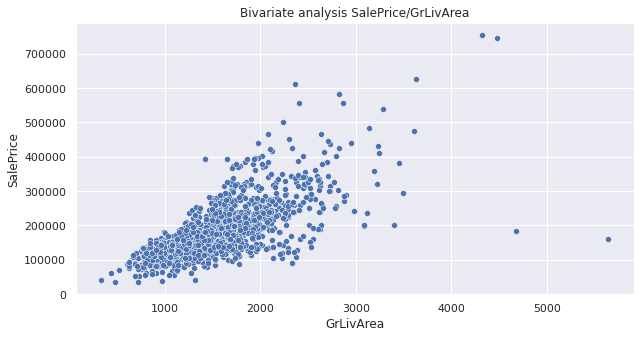

In [11]:
# Deleting GrLivArea outliers
outliers_index = train_data.sort_values(by="GrLivArea", ascending=False)[:2]

for index in outliers_index:
    train_data = train_data.drop(train_data[train_data["Id"] == index].index)

bivariate_analysis(numerical_features[0], target_variable)


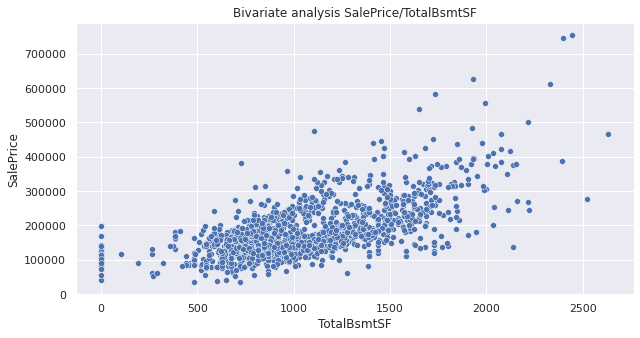

In [12]:
outliers_index = train_data[train_data["TotalBsmtSF"] > 3000]["Id"]
for index in outliers_index:
    train_data = train_data.drop(train_data[train_data["Id"] == index].index)

bivariate_analysis(numerical_features[1], target_variable)


### Data normality

In [13]:
def feature_normality_analysis(feature):
    # Statistical information
    print(train_data[feature].describe())
    # Sale price normalized histogram
    fig = plt.figure(figsize=(10, 5))
    sns.distplot(train_data[feature], fit=norm).set(
        title=feature + " normalized histogram"
    )
    # Sale price distribution plot
    fig = plt.figure(figsize=(10, 5))
    res = stats.probplot(train_data[feature], plot=plt)


count      1455.000000
mean     180433.811684
std       78651.429700
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      213750.000000
max      755000.000000
Name: SalePrice, dtype: float64
count    1455.000000
mean     1508.591065
std       505.849893
min       334.000000
25%      1128.000000
50%      1458.000000
75%      1775.500000
max      4476.000000
Name: GrLivArea, dtype: float64
count    1455.000000
mean     1048.178007
std       404.127796
min         0.000000
25%       795.000000
50%       990.000000
75%      1292.000000
max      2633.000000
Name: TotalBsmtSF, dtype: float64


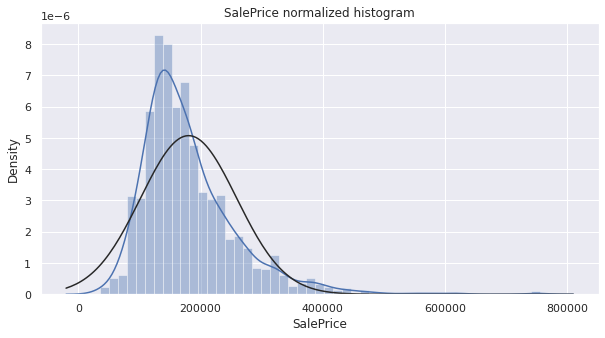

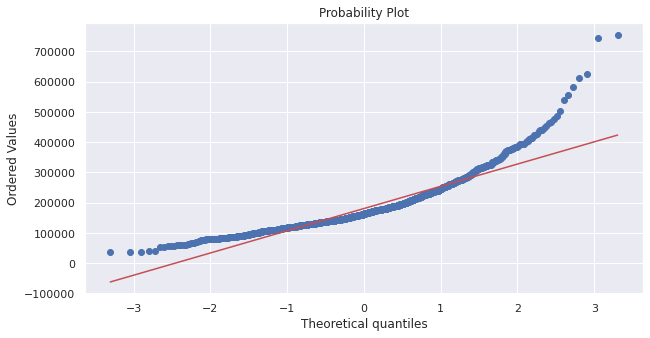

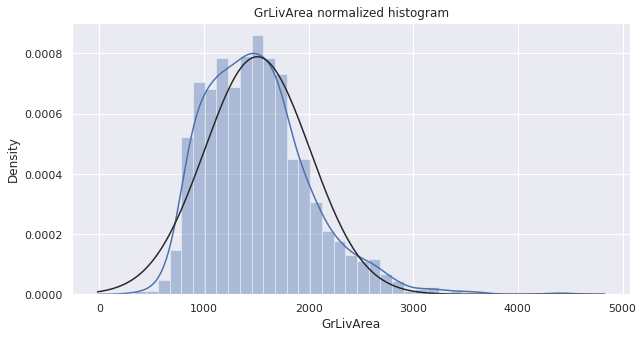

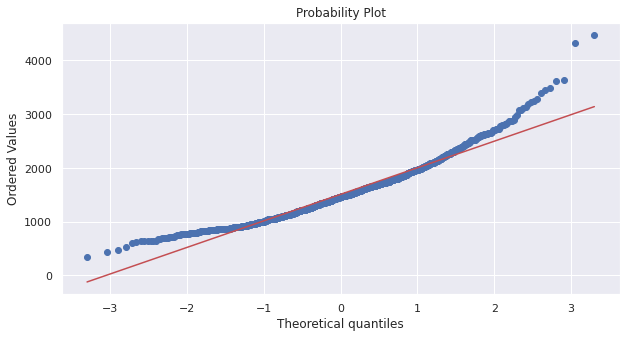

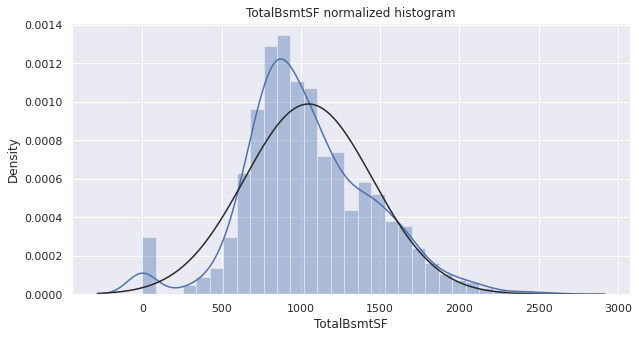

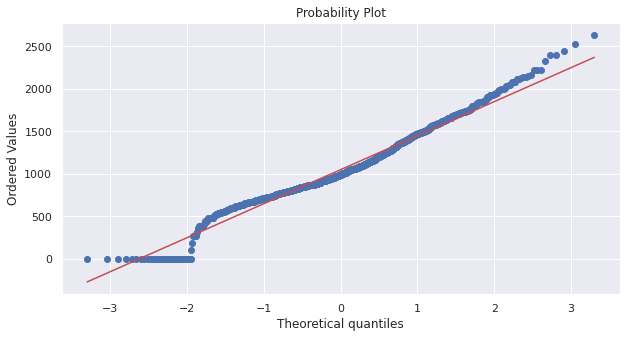

In [14]:
feature_normality_analysis(target_variable)
for feature in numerical_features:
    feature_normality_analysis(feature)


#### Data transformation

In [15]:
def log_transformation(feature):
    train_data[feature] = np.log(train_data[feature])

In [16]:
def transform_TotalBsmtSF():
    feature = numerical_features[1]
    train_data['HasBsmt'] = np.where(train_data[feature] > 0, 1, 0)
    def log(x):
        if x > 0:
            return np.log(x)
        else:
            return x
    train_data[feature] = train_data[feature].apply(log)


count    1455.000000
mean       12.022165
std         0.397858
min        10.460242
25%        11.774520
50%        12.001505
75%        12.272562
max        13.534473
Name: SalePrice, dtype: float64
count    1455.000000
mean        7.265019
std         0.329743
min         5.811141
25%         7.028201
50%         7.284821
75%         7.481837
max         8.406485
Name: GrLivArea, dtype: float64


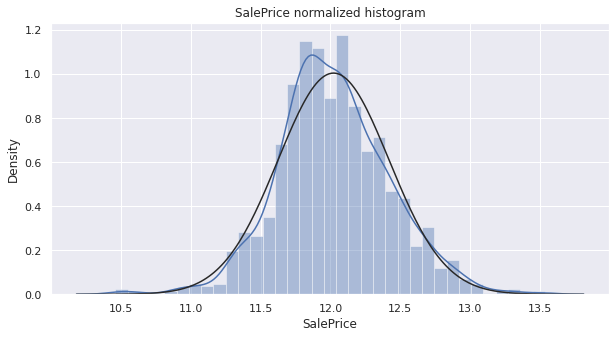

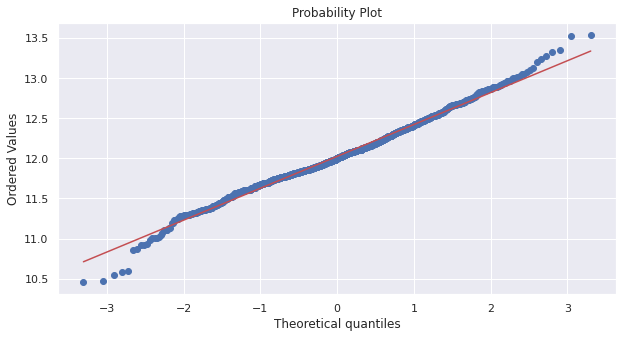

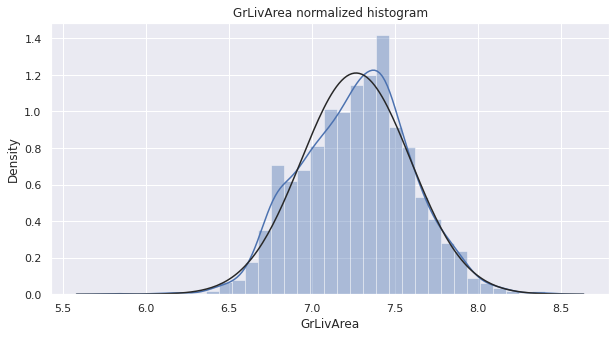

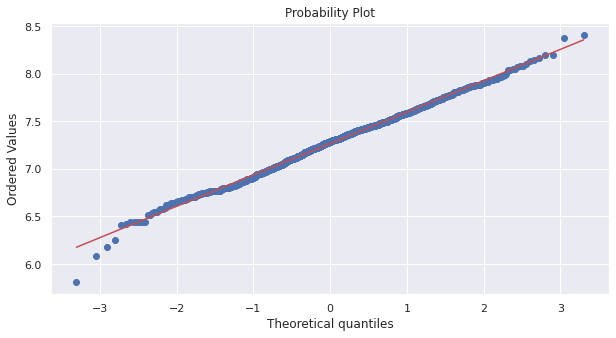

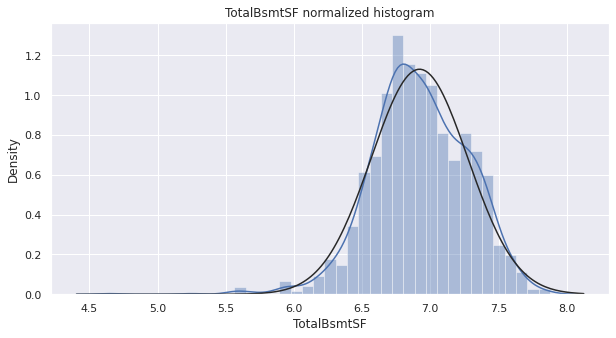

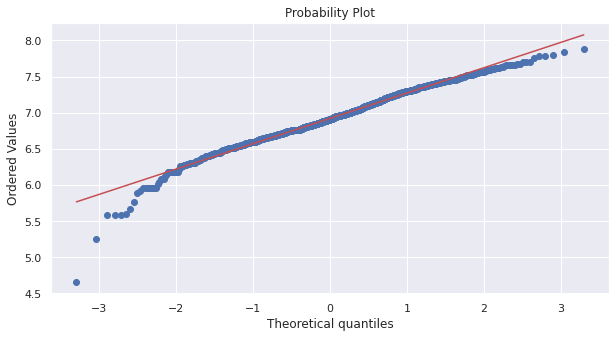

In [17]:
def normalize_numerical_data():
    log_transformation(target_variable) # Sale Price
    log_transformation(numerical_features[0]) # GrLivArea
    transform_TotalBsmtSF() # TotalBsmntSF

normalize_numerical_data()
feature_normality_analysis(target_variable)
feature_normality_analysis(numerical_features[0])

fig = plt.figure(figsize=(10, 5))
sns.distplot(train_data[train_data['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm).set(
    title=feature + " normalized histogram"
)
# Sale price distribution plot
fig = plt.figure(figsize=(10, 5))
res = stats.probplot(train_data[train_data['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

### Homoscedasticity

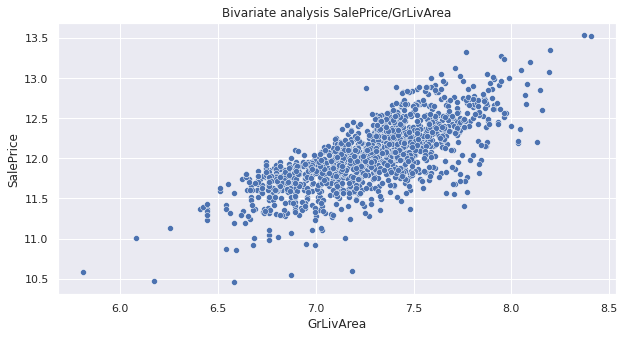

In [19]:
bivariate_analysis(numerical_features[0], target_variable)


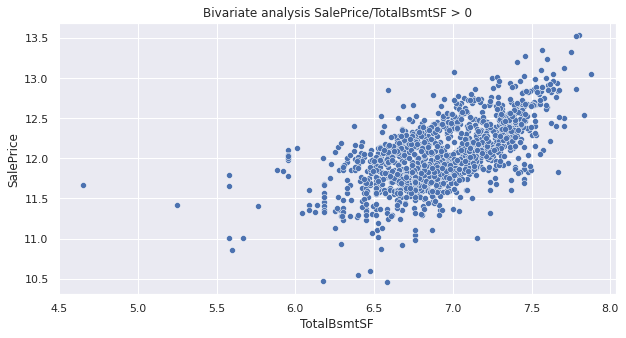

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(
    x=train_data[train_data["TotalBsmtSF"] > 0]["TotalBsmtSF"],
    y=train_data["SalePrice"],
    ax=ax,
).set(title="Bivariate analysis SalePrice/TotalBsmtSF > 0")


### Categorical to indicators

In [27]:
train_data = train_data.drop('Id', axis=1)
train_data = pd.get_dummies(train_data)
train_data.head()


,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,HasBsmt
0,12.247694,7,7.444249,2,6.752270,2,2003,1
1,12.109011,6,7.140453,2,7.140453,2,1976,1
2,12.317167,7,7.487734,2,6.824374,2,2001,1
3,11.849398,7,7.448334,3,6.628041,1,1915,1
4,12.429216,8,7.695303,3,7.043160,2,2000,1


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e68273de-9c0e-4792-b2f1-0ba159abf6d8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>